<a href="https://colab.research.google.com/github/FelipeGonzalezGarrido/Coding-Dojo/blob/main/3.%20Advanced%20Machine%20Learning/Semana%203%20-%20Introduction%20to%20Deep%20Learning/12.RNN_en_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

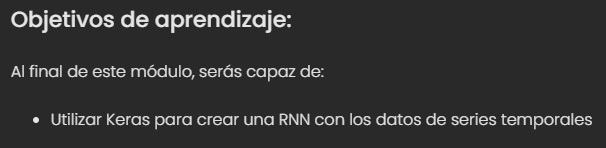

##**RNN en Keras**

Monta los datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importa las bibliotecas

In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

**Importa los datos**

El conjunto de datos que utilizaremos proviene de [Yahoo Finance](https://finance.yahoo.com/quote/AAPL/history?p=AAPL&.tsrc=fin-srch) y refleja la cotización diaria de las acciones de Apple (AAPL). Puedes descargar los datos [aquí](https://s3.amazonaws.com/General_V88/boomyeah2015/codingdojo/curriculum/content/chapter/AAPL.csv). Vamos a ver si podemos utilizar los datos históricos para predecir los precios de cierre del próximo mes. Para este ejemplo, utilizaremos datos de entrenamiento desde el 1 de enero de 2013 hasta el 31 de diciembre de 1019, y nuestro conjunto de prueba será el mes de enero de 2020.

Puesto que esto son datos de serie temporal, una RNN es una gran opción para trabajar con estos datos.

In [ ]:
# Get data
aapl = pd.read_csv('/content/drive/MyDrive/Data CodingDojo/AAPL.csv', index_col = 'Date')
aapl.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,17.065252,560518000
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.849854,352965200
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.380503,594333600
2013-01-07,18.642857,18.903572,18.400000,18.710714,16.284145,484156400
2013-01-08,18.900356,18.996071,18.616072,18.761072,16.327978,458707200


Visualicemos el precio de cierre de las acciones de Apple a lo largo del tiempo.

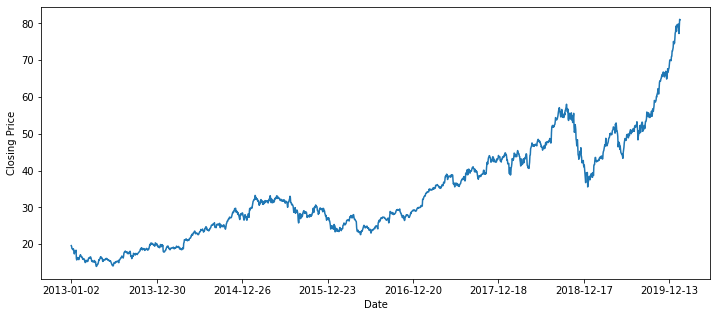

In [ ]:
plt.figure(figsize = (12, 5))
aapl['Close'].plot()
plt.ylabel('Closing Price');


Divide train/test

Puesto que estamos trabajando con datos a lo largo del tiempo, no queremos dividir nuestros datos aleatoriamente en conjuntos de entrenamiento y de prueba. Utilizaremos el último mes de nuestro conjunto de datos (enero de 2020) como nuestro conjunto de prueba.

In [ ]:
# Split data into training and testing - testing is month of January 2020
# We will also only use the closing column
train = aapl.loc['2013-01-02':'2019-12-31', ['Close']]
test = aapl.loc['2020-01-01':'2020-01-31', ['Close']]

Escala los datos

Como siempre, debido a que estamos utilizando una red neuronal, debemos escalar nuestros datos. En este caso, utilizaremos MinMaxScaler para escalar nuestros datos entre 0 y 1.

In [ ]:
# Scale data between 0 and 1
scaler = MinMaxScaler(feature_range = (0, 1))
train = scaler.fit_transform(train)
test = scaler.transform(test)

Remodela los datos

Ahora necesitamos remodelar nuestros datos. En las RNN, utilizamos un número anterior de marcas de tiempo para predecir los próximos valores. Para este ejemplo, utilizaremos los 5 días anteriores de precios de cierre para predecir los precios de cierre del día siguiente. Para hacer esto, necesitamos guardar los precios de las acciones de los 5 días anteriores para nuestro conjunto de características.

También necesitamos que nuestros datos sean de 3 dimensiones para pasarlos a través de una capa RNN (utilizaremos una capa LSTM para ejemplo). La primera dimensión es el número de filas, la segunda es el número de pasos de tiempo (días) que estamos utilizando para predecir el precio del día siguiente y la tercera es el número de características. Para este ejemplo, nuestra dimensión será (128, 5, 1), ya que nuestras secuencias de entrenamiento tiene 128 valores, estamos utilizando los últimos 5 días para predecir el día siguiente, y solo usaremos el precio de cierre.

Vamos a utilizar el [TimeseriesGenerator](https://keras.io/api/preprocessing/timeseries/#timeseriesgenerator-class) en Keras para obtener los datos en el formato que necesitamos para una RNN. El siguiente código logra esto. Alternativamente, podrías hacer esto a mano. Puedes ver un ejemplo de esta técnica [aquí](https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library).

In [ ]:
# Reshape data into sequences using TimeseriesGenerator
train_features = TimeseriesGenerator(train, train, length = 5)

##**Paso 1: definir nuestra estructura de red**

In [ ]:
# Step 1: Define our network structure
# Save the input shape
input_shape = train_features[0][0][0].shape
input_shape

(5, 1)

In [ ]:
# Sequential model
model = Sequential()

¡Ahora podemos agregar nuestras capas ocultas! Utilizaremos las tres capas LSTM en esta red.

Dado que estamos haciendo una regresión, la función de activación lineal se utilizará en nuestra capa de salida.

In [ ]:
# LSTM layer
model.add(LSTM(units = 50, 
               return_sequences = True, # True if next layer will be a recurrent layer
               input_shape = input_shape))
model.add(LSTM(units = 50, 
               return_sequences = True))
model.add(LSTM(units = 50, 
               return_sequences = False))
# Output layer
model.add(Dense(units = 1, activation = 'linear'))

##**Paso 2: compilar nuestro modelo**

Puesto que este es un problema de regresión, utilizaremos el error cuadrático medio como nuestra función de pérdida.

In [ ]:
# Step 2: Compile
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

##**Paso 3: ajustar nuestro modelo**

In [ ]:
# Step 3: Fit our model
history = model.fit(train_features, 
                    epochs=100)

Epoch 1/100
14/14 [==============================] - 12s 20ms/step - loss: 0.1098
Epoch 2/100
14/14 [==============================] - 0s 20ms/step - loss: 0.0282
Epoch 3/100
14/14 [==============================] - 0s 19ms/step - loss: 0.0278
Epoch 4/100
14/14 [==============================] - 0s 27ms/step - loss: 0.0145
Epoch 5/100
14/14 [==============================] - 1s 54ms/step - loss: 0.0068
Epoch 6/100
14/14 [==============================] - 1s 37ms/step - loss: 0.0021
Epoch 7/100
14/14 [==============================] - 1s 38ms/step - loss: 9.8662e-04
Epoch 8/100
14/14 [==============================] - 0s 27ms/step - loss: 4.8470e-04
Epoch 9/100
14/14 [==============================] - 0s 25ms/step - loss: 6.9054e-04
Epoch 10/100
14/14 [==============================] - 0s 24ms/step - loss: 6.2805e-04
Epoch 11/100
14/14 [==============================] - 0s 27ms/step - loss: 5.2378e-04
Epoch 12/100
14/14 [==============================] - 0s 19ms/step - loss: 8.8868e-04


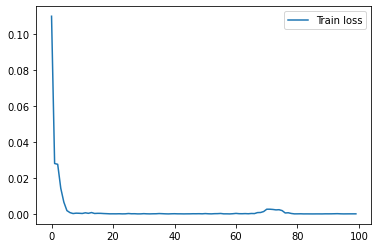

In [ ]:
# Visualize the loss
plt.plot(history.history['loss'], label='Train loss')
plt.legend();

**Predice los precios de las acciones para el mes de enero de 2020**

Ahora predigamos los precios de cierre para el mes de enero de 2020 utilizando los precios de cierre de los 5 días anteriores. Para hacer esto, necesitamos hacer el mismo preprocesamiento a nuestros datos de prueba que hicimos con nuestros datos de entrenamiento.

In [ ]:
test_features = TimeseriesGenerator(test, test, length = 5)

Podemos guardar nuestras predicciones en nuestro conjunto de prueba:



In [ ]:
preds = model.predict(test_features)

1/1 [==============================] - 1s 1s/step


Y ahora visualizaremos nuestras predicciones de modelo comparado con los precios de cierre reales para las acciones de Apple para el mes de enero de 2020:

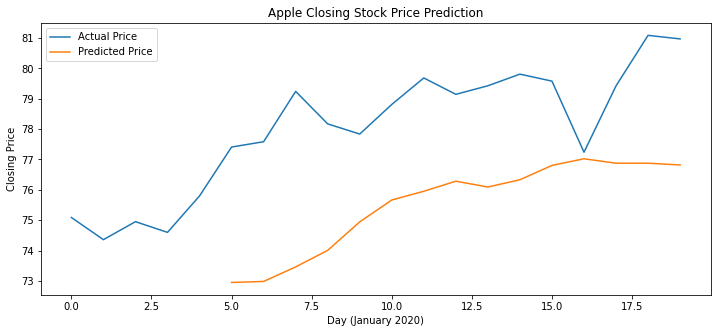

In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(scaler.inverse_transform(test), label='Actual Price')
# Note: there are less prices for the predicted price than the actual price, 
# because we need to use 5 days of prices to create our first prediction
plt.plot(range(5, len(test)), scaler.inverse_transform(preds), label='Predicted Price')
plt.title('Apple Closing Stock Price Prediction')
plt.xlabel('Day (January 2020)')
plt.ylabel('Closing Price')
plt.legend();